<a href="https://colab.research.google.com/github/yuhannie7/AI_in_tranportation/blob/main/Introduction_to_Pytorch_Part_2_Nie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Pytorch - Part 2

We will be training on a GPU for this exercise, don't forget to switch the runtime if you haven't done it yet!

In [ ]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In preparation for the secand part of the lab, let's install the torchgeo package. We'll only need it at the end of the lab, but it might require a restart of the runtime. It's easier to do that right now, so you won't lose all your variables.

In [ ]:
!pip install torchgeo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 242.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.0/849.0 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 36.0 MB/s eta 0

In [ ]:
import torch
from torch import nn

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

# Multi-dimensional inputs and Binary Classification

Below is an example of a two-dimensional dataset, where each point corresponds to a class. (Think of these as for example the height and weight of a person and the class as whether they are from Sweden or Italy.)

Notice: x,y doesn't correspond to the usual axes anymore. We are now plotting the two components of x, and y is a binary variable [0,1]

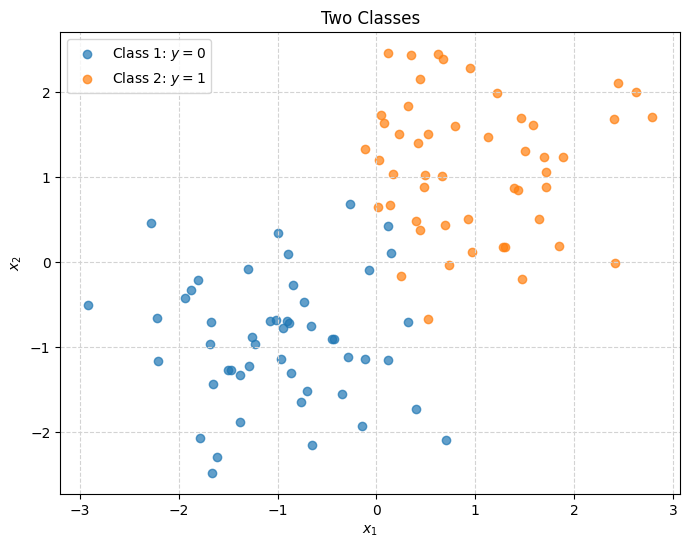

In [ ]:
# Generate data for two classes
np.random.seed(0)
n_samples = 100

# Class 1
class1_x = np.random.normal(loc=-1.0, scale=0.75, size=(n_samples // 2, 2))
class1_y = np.zeros(n_samples // 2)

# Class 2
class2_x = np.random.normal(loc=1.0, scale=0.75, size=(n_samples // 2, 2))
class2_y = np.ones(n_samples // 2)

# Combine data
x_data = np.concatenate((class1_x, class2_x))
y_data = np.concatenate((class1_y, class2_y))

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(x_data[y_data == 0, 0], x_data[y_data == 0, 1], label="Class 1: $y = 0$", alpha=0.7)
plt.scatter(x_data[y_data == 1, 0], x_data[y_data == 1, 1], label="Class 2: $y = 1$", alpha=0.7)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Two Classes")
plt.legend()
plt.grid(True, linestyle="--", color="lightgray")
plt.show()

In [ ]:
from torch.utils.data import DataLoader, Dataset

class SimpleDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = np.expand_dims(np.array(x_data, dtype=np.float32), 1)
        self.y_data = np.expand_dims(np.array(y_data, dtype=np.float32), 1)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Create the dataset and dataloader
dataset = SimpleDataset(x_data, y_data)

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True) # Adjust batch size as needed

print("Number of batches: ", len(train_dataloader))

Number of batches:  13


Below, we have defined our network so that it accepts two inputs, and produces one output in the 0-1 range using a Sigmoid nonlinearity.

Pytorch has a built in criterion function for binary classification called BCELoss that we are using here.

In [ ]:
# Define our model layers and nonlinearities
class FullyConnected(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(2, 32)
        self.s1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(32, 32)
        self.s2 = torch.nn.ReLU()
        self.l3 = torch.nn.Linear(32, 32)
        self.s3 = torch.nn.ReLU()
        self.l4 = torch.nn.Linear(32, 1)
        self.s4 = torch.nn.Sigmoid()

    # The forward() function defines what our model does to our data
    # Think of it as a function f(x) -> y
    def forward(self, x):
        x_1 = self.s1(self.l1(x))
        x_2 = self.s2(self.l2(x_1))
        x_3 = self.s3(self.l3(x_2))
        x_4 = self.s4(self.l4(x_3))
        return x_4.squeeze(1)

# Create an instance of the model
model = FullyConnected()
model = model.to(device) # Transfer it to the GPU for faster training

# Define the loss function and optimizer
criterion = torch.nn.BCELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)


losses = []
y_pred_inter = []
loss_avg = 1.0

# Training loop for Stochastic Gradient Descent
for epoch in range(1000):
    for x, y in train_dataloader:
      x, y = x.to(device), y.to(device)  # Move data to the GPU
      # Forward pass
      y_pred = model(x)
      loss = criterion(y_pred, y)

      # Backward pass
      optimizer.zero_grad()  # Reset gradients
      loss.backward()  # Calculate gradients
      optimizer.step()  # Update model parameters
      loss_avg = 0.95 * loss_avg + 0.05 * loss.item() # Take a running average of the loss over minibatches

    # Save the loss
    losses.append(loss.item())

    # Print the loss
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} - Loss: {loss_avg:.2f}")

Epoch: 0 - Loss: 3.10
Epoch: 100 - Loss: 4.88
Epoch: 200 - Loss: 4.04
Epoch: 300 - Loss: 2.55
Epoch: 400 - Loss: 1.43
Epoch: 500 - Loss: 0.95
Epoch: 600 - Loss: 0.76
Epoch: 700 - Loss: 0.66
Epoch: 800 - Loss: 0.61
Epoch: 900 - Loss: 0.56


In [ ]:
def plot_loss(losses, alpha = 0.05):
  plt.figure(figsize=(9, 5))
  # Apply exponential smoothing
  smoothed_losses = []
  smoothed_loss = losses[0]
  for loss in losses:
      smoothed_loss = alpha * loss + (1 - alpha) * smoothed_loss
      smoothed_losses.append(smoothed_loss)

  plt.plot(smoothed_losses)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  # plt.title(f"Loss over Epochs ($\alpha = {alpha:.2}$)")
  plt.grid(True, linestyle="--", color="lightgray")
  plt.show()

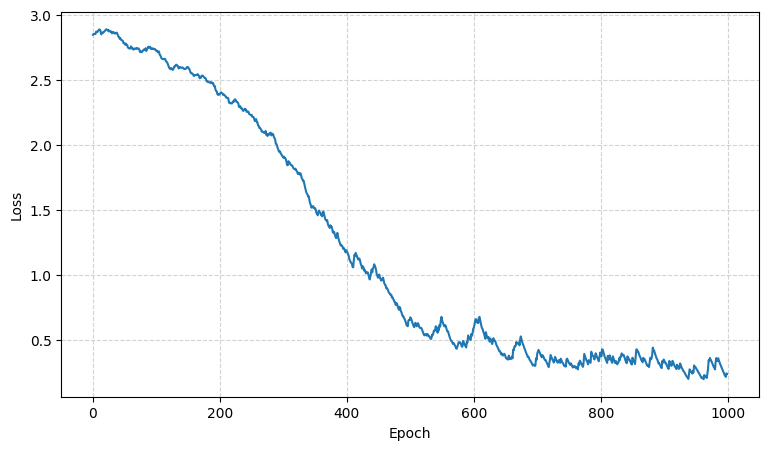

In [ ]:
plot_loss(losses)

A neat trick we can do with simple inputs like this, is we can evaluate the network for a dense grid of inputs, and then plot these values. This should give an insight of the so called decision boundaries of the network. Where the background is blue, y will evaluate to Class 1, where the background is orange, it will evaluate to Class 2.

In [ ]:
from torch.utils.data import TensorDataset
import matplotlib.colors

def plot_decision_boundaries(model, x_data, y_data):
  # Create a grid over the space covered, just to demonstrate decision boudaries
  grid_x1, grid_x2 = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
  # Let's combine these into an evaluation dataset
  eval_dataset = TensorDataset(torch.tensor(np.vstack((grid_x1.ravel(), grid_x2.ravel())).T, dtype=torch.float))
  eval_dataloader = DataLoader(eval_dataset, batch_size=1)

  y_grid = []
  with torch.no_grad():
      for x in eval_dataloader:
          x = x[0].to(device)
          y_grid.append(model(x).cpu().numpy())

  cmap = matplotlib.colors.LinearSegmentedColormap.from_list('blue-orange', (
      (0.000, (0.122, 0.467, 0.706)),
      (0.500, (1.000, 1.000, 1.000)),
      (1.000, (1.000, 0.498, 0.055))))

  # Plot a contour plot and the training labels on top
  plt.figure(figsize=(8, 6))
  plt.contourf(grid_x1, grid_x2, np.array(y_grid).reshape(grid_x1.shape), cmap=cmap, alpha=0.35, levels=10)
  plt.scatter(x_data[y_data == 0, 0], x_data[y_data == 0, 1], label="Class 1: $y = 0$", edgecolors='white')
  plt.scatter(x_data[y_data == 1, 0], x_data[y_data == 1, 1], label="Class 2: $y = 1$", edgecolors='white')
  plt.xlabel("$x_1$")
  plt.ylabel("$x_2$")
  plt.title("Decision Boundaries")
  plt.legend()
  plt.grid(True, linestyle="--", color="lightgray")
  plt.show()

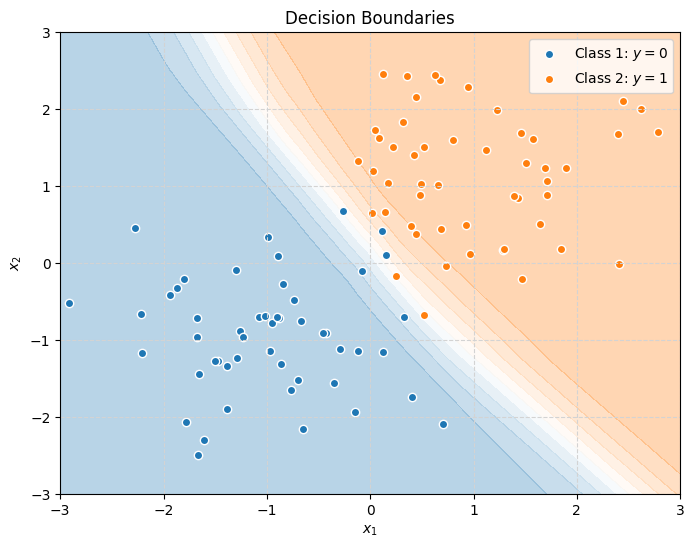

In [ ]:
plot_decision_boundaries(model, x_data, y_data)

# Regularization

Let's try the previous exercise with noisy data!

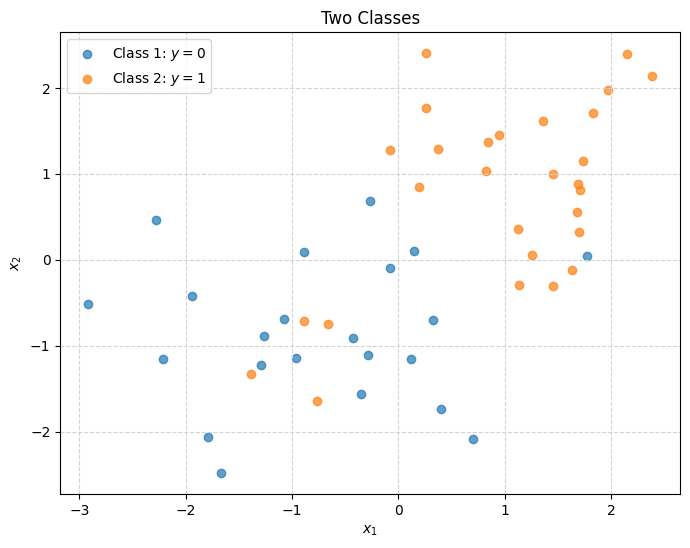

In [ ]:
np.random.seed(0)
n_samples = 50

# Class 1
class1_x = np.random.normal(loc=-1.0, scale=0.75, size=(n_samples // 2, 2))
# Let's randomly flip the class of 10% of our samples
class1_y = np.zeros(n_samples // 2) + (np.random.rand(n_samples // 2) < 0.1)

# Class 2
class2_x = np.random.normal(loc=1.0, scale=0.75, size=(n_samples // 2, 2))
# Let's randomly flip the class of 10% of our samples
class2_y = np.ones(n_samples // 2) - (np.random.rand(n_samples // 2) < 0.1)

# Combine data
x_data = np.concatenate((class1_x, class2_x))
y_data = np.concatenate((class1_y, class2_y))

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(x_data[y_data == 0, 0], x_data[y_data == 0, 1], label="Class 1: $y = 0$", alpha=0.7)
plt.scatter(x_data[y_data == 1, 0], x_data[y_data == 1, 1], label="Class 2: $y = 1$", alpha=0.7)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Two Classes")
plt.legend()
plt.grid(True, linestyle="--", color="lightgray")
plt.show()

In [ ]:
dataset = SimpleDataset(x_data, y_data)
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
# Create an instance of the model
model = FullyConnected()
model = model.to(device) # Transfer it to the GPU for faster training

# Define the loss function and optimizer
criterion = torch.nn.BCELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)

losses = []
coefficients = []
y_pred_inter = []
loss_avg = 1.0

# Training loop for Stochastic Gradient Descent
for epoch in range(5000):
    for x, y in train_dataloader:
      x, y = x.to(device), y.to(device)  # Move data to the GPU
      # Forward pass
      y_pred = model(x)
      loss = criterion(y_pred, y)

      # Backward pass
      optimizer.zero_grad()  # Reset gradients
      loss.backward()  # Calculate gradients
      optimizer.step()  # Update model parameters
      loss_avg = 0.95 * loss_avg + 0.05 * loss.item()

    # Save the loss
    losses.append(loss.item())

    # Print the loss
    if epoch % 500 == 0:
        print(f"Epoch: {epoch} - Loss: {loss_avg:.2f}")

Epoch: 0 - Loss: 1.80
Epoch: 500 - Loss: 1.20
Epoch: 1000 - Loss: 1.17
Epoch: 1500 - Loss: 1.03
Epoch: 2000 - Loss: 0.96
Epoch: 2500 - Loss: 0.84
Epoch: 3000 - Loss: 0.71
Epoch: 3500 - Loss: 0.59
Epoch: 4000 - Loss: 0.52
Epoch: 4500 - Loss: 0.43


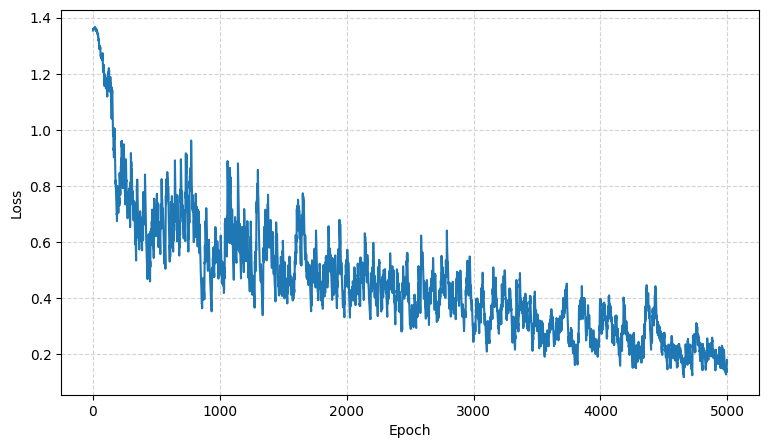

In [ ]:
plot_loss(losses)

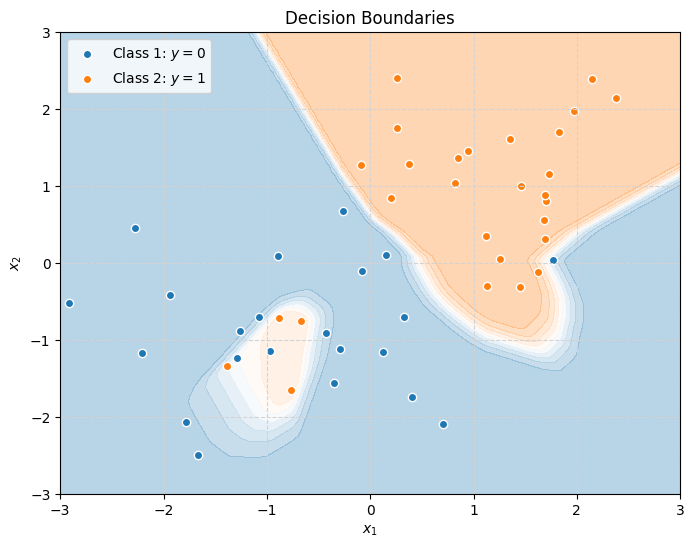

In [ ]:
plot_decision_boundaries(model, x_data, y_data)

You can see that even though we selected our data points mostly from two gaussian distributions, our model also learns the noise. To evaluate how good our model is, we will need a seperate set of data that is not part of our training set!

## Exercise 0:
Generate another set of data from the same distributions as above. You will have to either remove the line that sets the seed of the random number generator, or change it's value to get different data.

Run both the training data and the evaluation data through your model, and calculate and the accruracy of your model on both of these.

`accuracy = ratio of correct predictions / number of all predictions`

To do this, you will have to threshold your floating point predictions to a binary 1 or 0. Use a threshold of 0.5 for this example: `thresholded_y_pred = y_pred > 0.5`.

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score

# Generate another set of data
n_samples = 100

# Class 1
test_class1_x = np.random.normal(loc=-1.0, scale=0.75, size=(n_samples // 2, 2))
test_class1_y = np.zeros(n_samples // 2) + (np.random.rand(n_samples // 2) < 0.1)

# Class 2
test_class2_x = np.random.normal(loc=1.0, scale=0.75, size=(n_samples // 2, 2))
test_class2_y = np.ones(n_samples // 2) - (np.random.rand(n_samples // 2) < 0.1)

x_test = np.vstack((test_class1_x, test_class2_x))
y_test = np.concatenate((test_class1_y, test_class2_y))


def evaluate_model(model, x_data, y_data, dataset_name="Dataset"):
    with torch.no_grad():
        x_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
        y_pred = model(x_tensor).cpu().numpy()
        y_pred_thresholded = (y_pred > 0.5).astype(int)  #Use a threshold of 0.5

    # Calculate Accuracy
    accuracy = accuracy_score(y_data, y_pred_thresholded)
    print(f"{dataset_name} Accuracy: {accuracy:.2%}")

    return accuracy

train_accuracy = evaluate_model(model, x_data, y_data, "Training Set")

test_accuracy = evaluate_model(model, x_test, y_test, "Test Set")


Training Set Accuracy: 96.00%
Test Set Accuracy: 82.00%


## Exercise 1:
Set the weight decay parameter of SGD to a few values between 0.001 and 1 (on a roughly exponential scale), and see how the model reacts! What happens to the loss? What happens to the decision boudary? Try and replicate the decision boundary you achieved without the noise in your data! Can we say that a model with lower loss is always a better model?


Training with weight_decay=0.001...

Training with weight_decay=0.01...

Training with weight_decay=0.1...

Training with weight_decay=1.0...


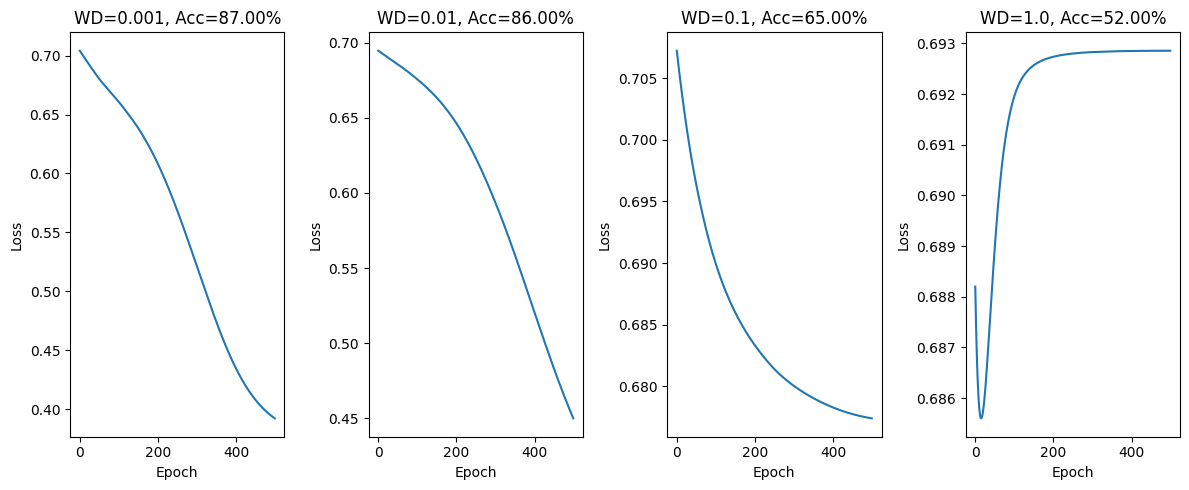

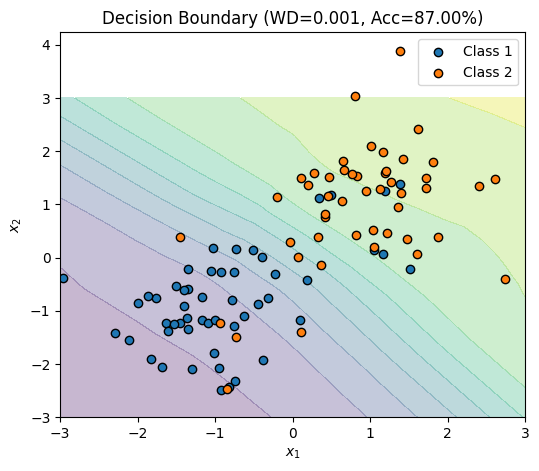

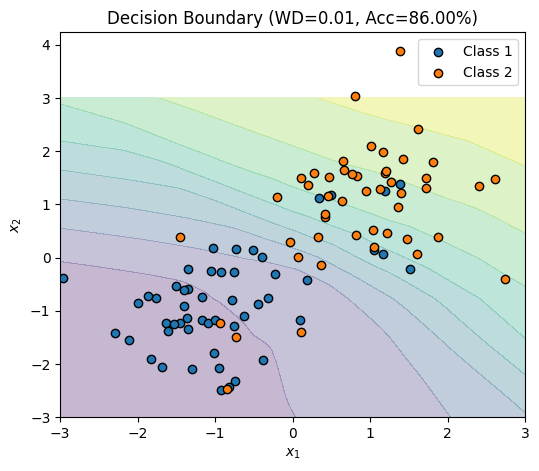

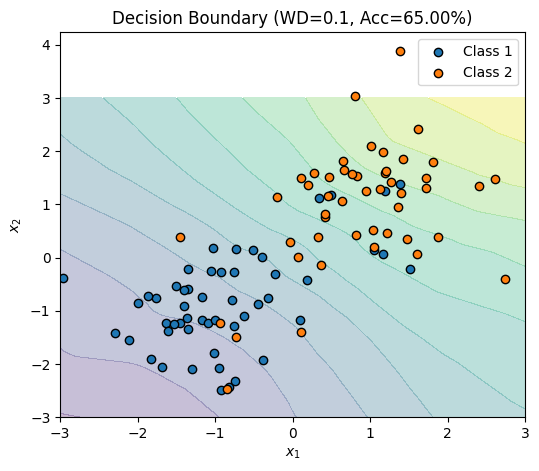

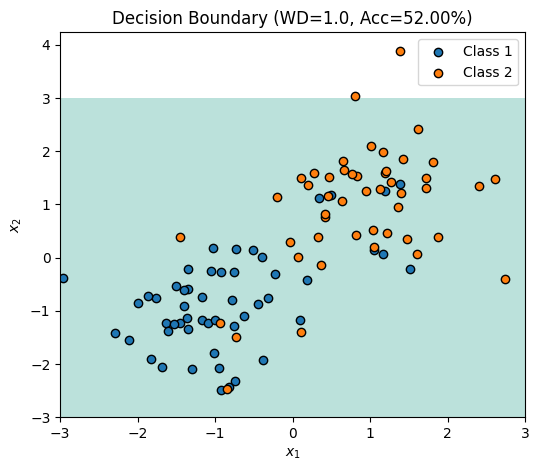

In [ ]:
import torch.optim as optim

# Define our model layers and nonlinearities
class FullyConnected(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(2, 32)
        self.s1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(32, 32)
        self.s2 = torch.nn.ReLU()
        self.l3 = torch.nn.Linear(32, 32)
        self.s3 = torch.nn.ReLU()
        self.l4 = torch.nn.Linear(32, 1)
        self.s4 = torch.nn.Sigmoid()

    # The forward() function defines what our model does to our data
    # Think of it as a function f(x) -> y
    def forward(self, x):
        x_1 = self.s1(self.l1(x))
        x_2 = self.s2(self.l2(x_1))
        x_3 = self.s3(self.l3(x_2))
        x_4 = self.s4(self.l4(x_3))
        return x_4.squeeze(1)

np.random.seed(42)
n_samples = 100

# Class 1
class1_x = np.random.normal(loc=-1.0, scale=0.75, size=(n_samples // 2, 2))
class1_y = np.zeros(n_samples // 2) + (np.random.rand(n_samples // 2) < 0.1)  # 10% 噪声

# Class 2
class2_x = np.random.normal(loc=1.0, scale=0.75, size=(n_samples // 2, 2))
class2_y = np.ones(n_samples // 2) - (np.random.rand(n_samples // 2) < 0.1)  # 10% 噪声

# Combine data
x_data = np.vstack((class1_x, class2_x))
y_data = np.concatenate((class1_y, class2_y))

def train_and_evaluate(weight_decay):
    model = FullyConnected().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=weight_decay)

    losses = []
    for epoch in range(500):
        x_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_data, dtype=torch.float32).to(device)

        # Forward
        y_pred = model(x_tensor)
        loss = criterion(y_pred, y_tensor)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    with torch.no_grad():
        y_pred = model(x_tensor).cpu().numpy()
        y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_data, y_pred)

    return model, losses, accuracy

weight_decays = [0.001, 0.01, 0.1, 1.0]
results = {}

plt.figure(figsize=(12, 5))

for i, wd in enumerate(weight_decays):
    print(f"\nTraining with weight_decay={wd}...")
    model, losses, accuracy = train_and_evaluate(wd)
    results[wd] = {"model": model, "losses": losses, "accuracy": accuracy}

    plt.subplot(1, len(weight_decays), i + 1)
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"WD={wd}, Acc={accuracy:.2%}")

plt.tight_layout()
plt.show()

def plot_decision_boundary(model, title):
    grid_x1, grid_x2 = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
    eval_points = np.vstack((grid_x1.ravel(), grid_x2.ravel())).T
    eval_tensor = torch.tensor(eval_points, dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_grid = model(eval_tensor).cpu().numpy()
    y_pred_grid = y_pred_grid.reshape(grid_x1.shape)


    plt.figure(figsize=(6, 5))
    plt.contourf(grid_x1, grid_x2, y_pred_grid, alpha=0.3, levels=10)
    plt.scatter(x_data[y_data == 0, 0], x_data[y_data == 0, 1], label="Class 1", edgecolors="black")
    plt.scatter(x_data[y_data == 1, 0], x_data[y_data == 1, 1], label="Class 2", edgecolors="black")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.legend()
    plt.title(title)
    plt.savefig(f"decision_boundary_wd_{wd}.png", dpi=300, bbox_inches='tight')
    plt.show()


for wd, result in results.items():
    plot_decision_boundary(result["model"], f"Decision Boundary (WD={wd}, Acc={result['accuracy']:.2%})")


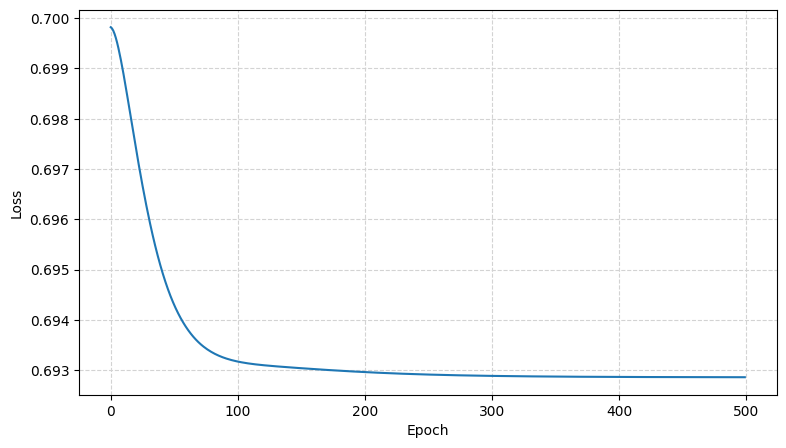

In [ ]:
plot_loss(losses)

# Torchgeo

Torchgeo is a library collecting datasets and models for geospatial data.

You can find the documentation here: https://torchgeo.readthedocs.io/

For this exercise, we will use the UC-Merced dataset:
https://torchgeo.readthedocs.io/en/stable/api/datasets.html#uc-merced

In [ ]:
import torchgeo
import torchgeo.datasets

ucm_train_dataset = torchgeo.datasets.UCMerced(root='./data', split='train', download=True, checksum=True)
ucm_eval_dataset = torchgeo.datasets.UCMerced(root='./data', split='val', download=True)

In [ ]:
# Let's see what we're cooking with
ucm_data_point = ucm_train_dataset[142]
print(ucm_data_point)

{'image': tensor([[[156., 152., 156.,  ..., 147., 147., 147.],
         [149., 149., 152.,  ..., 147., 147., 146.],
         [147., 149., 149.,  ..., 149., 147., 147.],
         ...,
         [ 39.,  39.,  42.,  ..., 107., 104., 104.],
         [ 42.,  39.,  42.,  ..., 102., 102., 102.],
         [ 46.,  42.,  46.,  ...,  98.,  99.,  99.]],

        [[150., 150., 151.,  ..., 147., 146., 143.],
         [147., 147., 148.,  ..., 143., 146., 146.],
         [150., 150., 147.,  ..., 146., 146., 147.],
         ...,
         [ 68.,  71.,  70.,  ...,  99.,  99., 102.],
         [ 70.,  68.,  71.,  ...,  97.,  99.,  97.],
         [ 70.,  70.,  71.,  ...,  94.,  99.,  97.]],

        [[147., 147., 144.,  ..., 142., 137., 139.],
         [144., 144., 144.,  ..., 139., 137., 144.],
         [144., 142., 142.,  ..., 139., 137., 142.],
         ...,
         [ 61.,  65.,  64.,  ...,  90.,  90.,  88.],
         [ 64.,  69.,  64.,  ...,  90.,  90.,  88.],
         [ 68.,  68.,  68.,  ...,  90.,  90

In [ ]:
# The image data is a tensor, in the shape of Channels x Height x Width
print(ucm_data_point["image"].shape)
print(ucm_data_point["image"].dtype)

torch.Size([3, 256, 256])
torch.float32


In [ ]:
# It looks like the images are in the range of 0-255.
# Usually neural networks work best with data input values normalized to the [-1, 1] range,
# So we will have to do something about this later.
print(ucm_data_point["image"].min(), ucm_data_point["image"].max())

tensor(17.) tensor(214.)


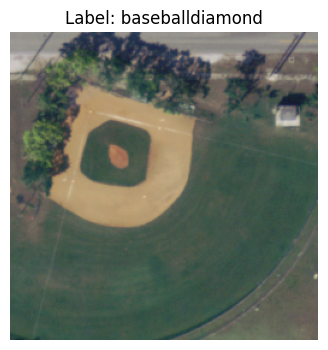

In [ ]:
# This dataset implementation comes with a handy function to plot data points
_ = ucm_train_dataset.plot(ucm_data_point)

In [ ]:
# Let's define the train and eval dataloaders.
ucm_train_dataloader = torch.utils.data.DataLoader(ucm_train_dataset, batch_size=16, shuffle=True)
ucm_eval_dataloader = torch.utils.data.DataLoader(ucm_eval_dataset, batch_size=1, shuffle=False)

The code below will help you evaluate the model accuracy on differet datasets.

Note how we call `model.eval()` before the evaluation, and `model.train()` after. This will be necessary for more complex models, where some layers behave differently during training and evaluation. (For example dropout and batchnorm layers, you should look them up if you are interested in the details.)

In [ ]:
def evaluate_model(model, dataloader):
  model.eval() # Set the model to evaluation mode
  running_loss = 0.0
  correct_predictions = 0
  total_predictions = 0

  with torch.no_grad():
      for data in dataloader:
          x = data["image"].to(device)
          y = data["label"].to(device)

          y_pred = model(x)

          _, predicted = torch.max(y_pred, 1)
          total_predictions += y.size(0)
          correct_predictions += (predicted == y).sum().item()

  accuracy = 100 * correct_predictions / total_predictions

  print(f"Accuracy: {accuracy:.2f}%")

  model.train() # Set the model back to training mode
  return accuracy

## Exercise 2:
Define a convolutional network below. Use the `Conv2d`, `ReLu`, and `Linear` layers.

The `torch.nn.CrossEntropyLoss()` criterion we use here includes the last `Sigmoid` layer from before, so the output of your network should be just a `Linear` layer.
It's input shape should be the size of your image after the convolutions, and it's output shape should correspond to the number of classes in the dataset.

In [ ]:
# Define our model layers and nonlinearities
import torch.nn as nn
import torch.nn.functional as F

class SmallConvnet(nn.Module):
    def __init__(self, num_classes=21):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()

        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(32 * 64 * 64, num_classes)  # input size is 256x256

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


# Create an instance of the model
model = SmallConvnet()
print(model)
model = model.to(device) # Transfer it to the GPU for faster training

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.1)

losses = []
coefficients = []
y_pred_inter = []
loss_avg = 1.0

# Training loop for Stochastic Gradient Descent
for epoch in range(10):
    for data in ucm_train_dataloader:
        x = data["image"].to(device)
        y = data["label"].to(device)
        # Forward pass
        y_pred = model(x)
        loss = criterion(y_pred, y)

        # Backward pass
        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update model parameters
        loss_avg = 0.95 * loss_avg + 0.05 * loss.item()

    # Save the loss
    losses.append(loss.item())

    # Print the loss
    if epoch % 2 == 0:
        print(f"Epoch: {epoch} - Loss: {loss_avg:.2f}")
        print("Eval dataset:")
        accuracy = evaluate_model(model, ucm_eval_dataloader)
        print("Train dataset:")
        accuracy = evaluate_model(model, ucm_train_dataloader)

SmallConvnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=131072, out_features=21, bias=True)
)
Epoch: 0 - Loss: 5.92
Eval dataset:
Accuracy: 17.14%
Train dataset:
Accuracy: 21.51%
Epoch: 2 - Loss: 0.83
Eval dataset:
Accuracy: 13.57%
Train dataset:
Accuracy: 34.05%
Epoch: 4 - Loss: 0.21
Eval dataset:
Accuracy: 48.57%
Train dataset:
Accuracy: 97.30%
Epoch: 6 - Loss: 0.11
Eval dataset:
Accuracy: 51.43%
Train dataset:
Accuracy: 99.21%
Epoch: 8 - Loss: 0.08
Eval dataset:
Accuracy: 51.67%
Train dataset:
Accuracy: 99.84%


In [ ]:
print("Eval dataset:")
accuracy = evaluate_model(model, ucm_eval_dataloader)
print("Train dataset:")
accuracy = evaluate_model(model, ucm_train_dataloader)

Eval dataset:
Accuracy: 49.76%
Train dataset:
Accuracy: 99.60%


## Exercise 3:
Visualize some images with the prediction results.

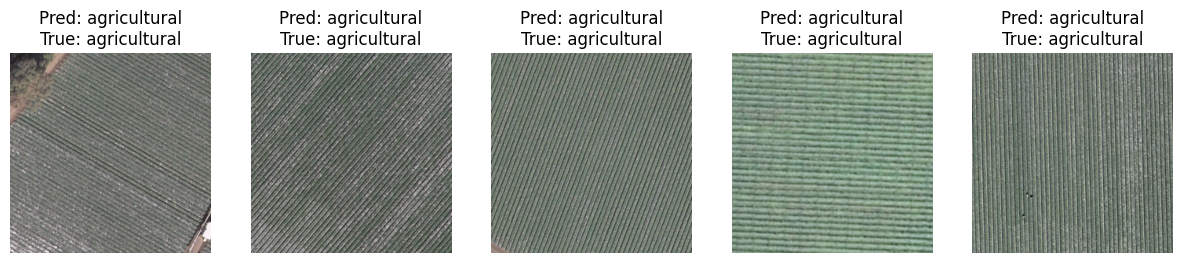

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

class_names = [
    "agricultural", "airplane", "baseballdiamond", "beach", "buildings", "chaparral", "denseresidential", "forest", "freeway",
    "golfcourse", "harbor", "intersection", "mediumresidential", "mobilehomepark", "overpass", "parkinglot", "river", "runway", "sparseresidential", "storagetanks", "tenniscourt"
]

def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    images, labels, preds = [], [], []

    with torch.no_grad():
        for data in dataloader:
            x = data["image"].to(device)
            y = data["label"].to(device)
            y_pred = model(x)
            _, predicted = torch.max(y_pred, 1)

            images.append(x.cpu().numpy())
            labels.append(y.cpu().numpy())
            preds.append(predicted.cpu().numpy())

            if len(images) >= num_images:
                break

    images = np.concatenate(images[:num_images], axis=0)
    labels = np.concatenate(labels[:num_images], axis=0)
    preds = np.concatenate(preds[:num_images], axis=0)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        img = images[i].transpose(1, 2, 0)
        img = img / 255.0
        ax.imshow(img)
        ax.set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        ax.axis("off")

    plt.show()

visualize_predictions(model, ucm_eval_dataloader, num_images=5)


# Large Convolutional Networks

## Excercise 4:

The torchvision library (`import torchvision`) contains a lot of popular pre-defined networks. Try to use one of these as the Model in your code. You will have to define some Linear layers after the network that transform the features to the right size for the number of classes in this dataset.

You might also have to reshape the input images to be the right size for some of the networks. The easiest way to do this is using the transforms module of torchvision:

`from torchvision.transforms import v2`

https://pytorch.org/vision/stable/transforms.html

You can define a `Resize` transform and pass it to the `transforms` parameter of the UC Merced dataset to resize all images retrieved from the dataset.

`torchgeo.datasets.UCMerced(..., transforms=resize)`

Why did you pick this particular network?

Compare this model to the small network you trained in the previous exercise. What validation accuracy did you manage to achieve? What was the time needed to train? How do these relate to the number of parametrs in these networks?

In [ ]:
import torchvision.models as models

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 21)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 66.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchgeo.datasets import UCMerced


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

ucm_train_dataset = UCMerced(root='./data', split='train', download=True)
ucm_eval_dataset = UCMerced(root='./data', split='val', download=True)

def collate_fn(batch):
    images = []
    labels = []

    for sample in batch:
        img = sample["image"]
        label = sample["label"]

        img = transforms.functional.resize(img, (224, 224))
        img = transforms.functional.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize

        images.append(img)
        labels.append(label)

    images = torch.stack(images)
    labels = torch.tensor(labels, dtype=torch.long)

    return images, labels

ucm_train_dataloader = DataLoader(ucm_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
ucm_eval_dataloader = DataLoader(ucm_eval_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

for images, labels in ucm_train_dataloader:
    print("Images shape:", images.shape)  # (batch_size, 3, 224, 224)
    print("Labels shape:", labels.shape)  # (batch_size,)
    break


Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [ ]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 21)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in ucm_train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(y_pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.3f}, Train Acc: {train_acc:.2f}%")


Epoch 1/10, Loss: 18.794, Train Acc: 88.02%
Epoch 2/10, Loss: 9.284, Train Acc: 93.57%
Epoch 3/10, Loss: 12.449, Train Acc: 92.30%
Epoch 4/10, Loss: 9.154, Train Acc: 93.17%
Epoch 5/10, Loss: 4.520, Train Acc: 97.06%
Epoch 6/10, Loss: 4.704, Train Acc: 97.86%
Epoch 7/10, Loss: 4.200, Train Acc: 96.67%
Epoch 8/10, Loss: 2.919, Train Acc: 97.94%
Epoch 9/10, Loss: 2.784, Train Acc: 98.65%
Epoch 10/10, Loss: 3.575, Train Acc: 97.78%


In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in ucm_eval_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 88.10%


## Optional:

If you want to explore Neural Network architectures, especially if you plan on using Pytorch in your project, you can also answer some (or all) of the following questions.

You can also ask questions in reply to these that you would like to know the answers for. If you do, I will comment on your observations, and answer your questions to the best of my ability when grading your lab. You can even do this part as a late submission if you do not have time left until the deadline.

* What are the main components of your selected network?
* What layers are included in each of these components?
* Are there any layers we haven't discussed in the lectures? What do they do?

Networks that come with pre-trained weights require inputs to be normalized to a certain range for optimal performance.
* Can you find this information about the network you are using? Does the performance (or the time in which this performance is acheved) change if you implement the correct normalization? (Again, you can use `from torchvision.transforms import v2` to implement this in a few lines.)

Overfitting is an ever present problem in deep neural networks. Some of it is adressed in the optimizer (for example the weight decay paramter we discussed in this lab), while others are inherent in the network architecture itself.
* What methods does your selected network employ to reduce overfitting?

Some of the networks included in `torchvision` are very similar to each other.
* Pick a different network, and try to match it's performance to the previous one. Did you have to use different hyperparameters?
* What similarities and differences do you see in the architecture of the previous network you picked versus the current one?